In [1]:
import numpy as np
from numba import jit, njit, prange
import matplotlib.pyplot as plt
from numpy import linalg as la
%matplotlib inline

# Testing the method

In [111]:
def eulcro(r, v, time, tau, GM):
    accel = -GM*r/la.norm(r)**3
    v = v + tau * accel
    r = r + tau * v
    time = time + tau
    return r, v, time

def interpf(x1,x,y):
    return (x1-x[1])*(x1-x[2])/((x[0]-x[1])*(x[0]-x[2]))*y[0]+(x1-x[0])*(x1-x[2])/\
((x[1]-x[0])*(x[1]-x[2]))*y[1]+(x1-x[0])*(x1-x[1])/\
((x[2]-x[0])*(x[2]-x[1]))*y[2]

def rk4(x,t,tau,derivsRK,param):
    half_tau = 0.5*tau
    F1 = derivsRK(x,t,param)  
    t_half = t + half_tau
    xtemp = x + half_tau*F1
    F2 = derivsRK(xtemp,t_half,param)  
    xtemp = x + half_tau*F2
    F3 = derivsRK(xtemp,t_half,param)
    t_full = t + tau
    xtemp = x + tau*F3
    F4 = derivsRK(xtemp,t_full,param)
    xout = x + tau/6.*(F1 + F4 + 2.*(F2+F3))
    return xout

def rka(x,t,tau,err,derivsRK,param):
    # Set initial variables
    tSave, xSave = t, x        # Save initial values
    safe1, safe2 = 0.9, 4.0    # Safety factors
    eps = 1.e-15

    # Loop over maximum number of attempts to satisfy error bound
    xTemp = np.empty(len(x))
    xSmall = np.empty(len(x))
    xBig = np.empty(len(x))
    maxTry = 100
    for iTry in range(maxTry):

        #* Take the two small time steps
        half_tau = 0.5 * tau
        xTemp = rk4(xSave,tSave,half_tau,derivsRK,param)
        t = tSave + half_tau
        xSmall = rk4(xTemp,t,half_tau,derivsRK,param)

        #* Take the single big time step
        t = tSave + tau
        xBig = rk4(xSave,tSave,tau,derivsRK,param)

        #* Compute the estimated truncation error
        scale = err * (abs(xSmall) + abs(xBig))/2.
        xDiff = xSmall - xBig
        errorRatio = np.max( np.absolute(xDiff) / (scale + eps) )

        #* Estimate new tau value (including safety factors)
        tau_old = tau
        tau = safe1*tau_old*errorRatio**(-0.20)
        tau = max(tau, tau_old/safe2)
        tau = min(tau, safe2*tau_old)

        #* If error is acceptable, return computed values
        if errorRatio < 1 :
            return np.array([xSmall, t, tau]) 

    #* Issue error message if error bound never satisfied
    print('ERROR: Adaptive Runge-Kutta routine failed')
    return np.array([xSmall, t, tau])

In [265]:
#Define the forces
def gravrk(s,t,GM):
    # Compute acceleration
    r = np.array([s[0], s[1]]) 
    v = np.array([s[2], s[3]])
    accel = -GM*r/la.norm(r)**3

    # Return derivatives [dr(1)/dt dr(2)/dt dv(1)/dt dv(2)/dt]
    deriv = np.array([v[0], v[1], accel[0], accel[1]])
    return deriv


# Figures 3.2 and 3.3

Numerical method?: 
1 - Euler 
2 - Euler-Cromer 
3 - Runge-Kutta 
4 - Adaptive Runge-Kutta
Method? 1


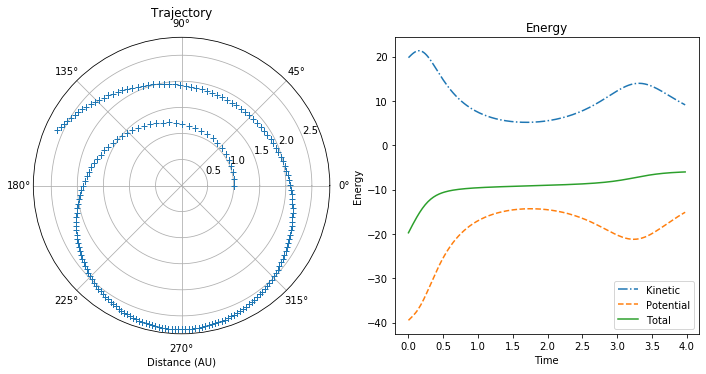

In [16]:
#Initialize variables

r0 = 1
v0 = 2*np.pi
nStep = 200
tau = .02
r = np.array([r0, 0])
v = np.array([0, v0])
state = np.array([r[0], r[1], v[0], v[1]])
errflag = 0

rplot=[]
tplot=[]
thplot=[]
kinetic=[]
potential=[]

#Physical constants

GM = 4*np.pi**2     #(AU^3/yr^2)
mass = 1            #Comet
adaptErr = 1e-3     #Adaptive error parameter
time = 0            #time, duh...

#Loop parameters

print('Numerical method?:','\n1 - Euler',
      '\n2 - Euler-Cromer','\n3 - Runge-Kutta',
      '\n4 - Adaptive Runge-Kutta')
Method = float(input('Method? '))
for i in range(nStep):
    
    #PLot arrays
    
    rplot.append(la.norm(r))
    thplot.append(np.arctan2(r[1],r[0]))
    tplot.append(time)
    kinetic.append(.5*mass*la.norm(v)**2)
    potential.append(-GM*mass/la.norm(r))

    #Numerical loops
    if Method == 1:
        accel = -GM*r/la.norm(r)**3
        r = r+ tau * v
        v = v+ tau * accel
        time = time + tau
    elif Method == 2:
        accel = -GM*r/la.norm(r)**3
        v = v+ tau * accel
        r = r+ tau * v
        time = time + tau
    elif Method == 3:
        state = rk4(state, time, tau, gravrk, GM)
        r = [state[0], state[1]]
        v = [state[2], state[3]]
        time = time + tau
    elif Method == 4:
        [state, time, tau] = rka(state, time, tau, adaptErr, gravrk, GM)
        r = [state[0], state[1]]
        v = [state[2], state[3]]
        time = time + tau
    else:
        errflag == 1
        print('Choose a correct method!')
    if errflag == 1:
        break
    
#plot trajectory

plt.figure(figsize = (12,12))
plt.subplot(221, projection = 'polar')
plt.title('Trajectory')
plt.polar(thplot, rplot, '+')
plt.xlabel('Distance (AU)')

#plot energy

plt.subplot(222)
plt.title('Energy')
totalE = np.array(kinetic) + np.array(potential)
plt.plot(tplot, kinetic, '-.', label = 'Kinetic')
plt.plot(tplot, potential, '--', label = 'Potential')
plt.plot(tplot, totalE, '-', label = 'Total')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.show()

Numerical method?: 
1 - Euler 
2 - Euler-Cromer 
3 - Runge-Kutta 
4 - Adaptive Runge-Kutta
Method? 2


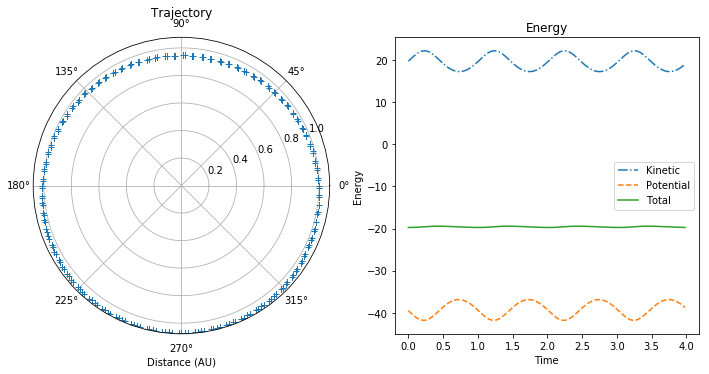

In [95]:
#Initialize variables

r0 = 1
v0 = 2*np.pi
nStep = 200
tau = .02
r = np.array([r0, 0])
v = np.array([0, v0])
state = np.array([r[0], r[1], v[0], v[1]])
errflag = 0

rplot=[]
tplot=[]
thplot=[]
kinetic=[]
potential=[]

#Physical constants

GM = 4*np.pi**2     #(AU^3/yr^2)
mass = 1            #Comet
adaptErr = 1e-3     #Adaptive error parameter
time = 0            #time, duh...

#Loop parameters

print('Numerical method?:','\n1 - Euler',
      '\n2 - Euler-Cromer','\n3 - Runge-Kutta',
      '\n4 - Adaptive Runge-Kutta')
Method = float(input('Method? '))
for i in range(nStep):
    
    #PLot arrays
    
    rplot.append(la.norm(r))
    thplot.append(np.arctan2(r[1],r[0]))
    tplot.append(time)
    kinetic.append(.5*mass*la.norm(v)**2)
    potential.append(-GM*mass/la.norm(r))

    #Numerical loops
    if Method == 1:
        accel = -GM*r/la.norm(r)**3
        r = r+ tau * v
        v = v+ tau * accel
        time = time + tau
    elif Method == 2:
        accel = -GM*r/la.norm(r)**3
        v = v+ tau * accel
        r = r+ tau * v
        time = time + tau
    elif Method == 3:
        state = rk4(state, time, tau, gravrk, GM)
        r = [state[0], state[1]]
        v = [state[2], state[3]]
        time = time + tau
    elif Method == 4:
        [state, time, tau] = rka(state, time, tau, adaptErr, gravrk, GM)
        r = [state[0], state[1]]
        v = [state[2], state[3]]
        time = time + tau
    else:
        errflag == 1
        print('Choose a correct method!')
    if errflag == 1:
        break
    
#plot trajectory

plt.figure(figsize = (12,12))
plt.subplot(221, projection = 'polar')
plt.title('Trajectory')
plt.polar(thplot, rplot, '+')
plt.xlabel('Distance (AU)')

#plot energy

plt.subplot(222)
plt.title('Energy')
totalE = np.array(kinetic) + np.array(potential)
plt.plot(tplot, kinetic, '-.', label = 'Kinetic')
plt.plot(tplot, potential, '--', label = 'Potential')
plt.plot(tplot, totalE, '-', label = 'Total')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.show()

# Figure 3.3 with vectorized code

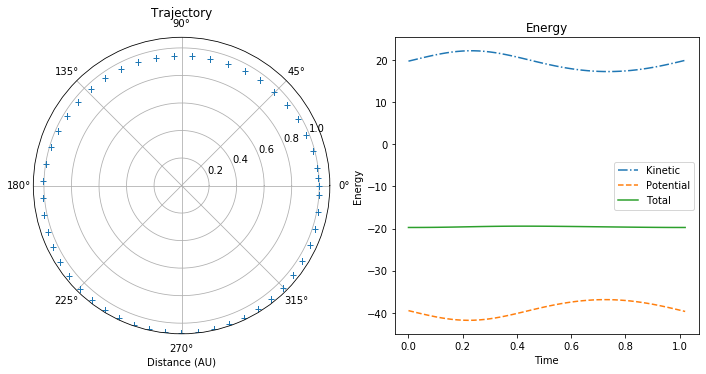

Energy Deviation over entire range: 1.6 
Energy Deviation on endpoints: 0.0027 


In [86]:
r0 = 1
v0 = 2*np.pi
nStep = 100000
tau = .02
time = 0
margin = 1e-1

GM = 4*np.pi**2     #(AU^3/yr^2)
mass = 1

r = np.array([r0, 0])
v = np.array([0, v0])
rplot = np.empty(nStep)
thplot = np.empty(nStep)
tplot = np.empty(nStep)
potential = np.empty(nStep)
kinetic = np.empty(nStep)

for i in range(nStep):
    rplot[i] = la.norm(r)
    thplot[i] = np.arctan2(r[1],r[0])
    tplot[i] = time
    kinetic[i] = .5*mass*la.norm(v)**2
    potential[i] = -GM*mass/la.norm(r)

    r, v, time = eulcro(r, v, time, tau, GM)

    if i > 1 / tau:
        if (rplot[i] < rplot[i - 1]) and np.abs(thplot[i]) < margin:
            break
            
i += 1
kinetic = kinetic[:i]
potential = potential[:i]
tplot = tplot[:i]
rplot = rplot[:i]
thplot = thplot[:i]
totalE = kinetic + potential
dev_E = np.abs((totalE[0] - totalE[-1])/np.mean(totalE)) * 100
dev_E_abs = np.abs((np.max(totalE) - np.min(totalE))/np.mean(totalE)) * 100

plt.figure(figsize = (12,12))
plt.subplot(221, projection = 'polar')
plt.title('Trajectory')
plt.polar(thplot, rplot, '+')
plt.xlabel('Distance (AU)')

plt.subplot(222)
plt.title('Energy')
totalE = np.array(kinetic) + np.array(potential)
plt.plot(tplot, kinetic, '-.', label = 'Kinetic')
plt.plot(tplot, potential, '--', label = 'Potential')
plt.plot(tplot, totalE, '-', label = 'Total')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.show()
print('Energy Deviation over entire range: %.2g \nEnergy Deviation on endpoints: %.2g '%
      (dev_E_abs, dev_E))

# Problem 3.6

In [5]:
'''
Warning: This cell takes quite a while to run
'''
r0 = 35
v0_lst = np.arange(1,0,-.1)
mass = 1            
GM = 4*np.pi**2     #(AU^3/yr^2)
nStep = 5000000

tau_lst = np.empty_like(v0_lst)
deve_lst = np.empty_like(v0_lst)
deve_abs_lst = np.empty_like(v0_lst)
j = 0

for v0 in v0_lst:
    dev_E = 2
    dev_E_abs = 2
    tau = v0

    while dev_E_abs > 1:
        print('Test', v0)
        r = np.array([r0, 0])
        v = np.array([0, v0])
        rplot = np.empty(nStep)
        thplot = np.empty(nStep)
        tplot = np.empty(nStep)
        potential = np.empty(nStep)
        kinetic = np.empty(nStep)
        time = 0
        i = 0

        for i in range(nStep):
                rplot[i] = la.norm(r)
                thplot[i] = np.arctan2(r[1],r[0])
                tplot[i] = time
                kinetic[i] = .5*mass*la.norm(v)**2
                potential[i] = -GM*mass/la.norm(r)

                r, v, time = eulcro(r, v, time, tau, GM)

                if i > int(1 / tau):
                    if (rplot[i] < rplot[i - 1]) and np.abs(thplot[i]) < 1e-3:
                        break

        i += 1
        kinetic = kinetic[:i]
        potential = potential[:i]
        totalE = kinetic + potential
        dev_E = np.abs((totalE[0] - totalE[-1])/np.mean(totalE)) * 100
        dev_E_abs = np.abs((np.max(totalE) - np.min(totalE))/np.mean(totalE)) * 100
        tauF = tau   
        tau *= .6

    tau_lst[j] = tau
    deve_lst[j] = dev_E
    deve_abs_lst[j] = dev_E_abs
        
    j += 1   

print('|-------- Completed --------|')



Test 1.0
Test 0.9
Test 0.9
Test 0.9
Test 0.9
Test 0.8
Test 0.8
Test 0.8
Test 0.8
Test 0.8
Test 0.8
Test 0.7000000000000001
Test 0.7000000000000001
Test 0.7000000000000001
Test 0.7000000000000001
Test 0.7000000000000001
Test 0.7000000000000001
Test 0.7000000000000001
Test 0.6000000000000001
Test 0.6000000000000001
Test 0.6000000000000001
Test 0.6000000000000001
Test 0.6000000000000001
Test 0.6000000000000001
Test 0.6000000000000001
Test 0.6000000000000001
Test 0.6000000000000001
Test 0.5000000000000001
Test 0.5000000000000001
Test 0.5000000000000001
Test 0.5000000000000001
Test 0.5000000000000001
Test 0.5000000000000001
Test 0.5000000000000001
Test 0.5000000000000001
Test 0.5000000000000001
Test 0.5000000000000001
Test 0.40000000000000013
Test 0.40000000000000013
Test 0.40000000000000013
Test 0.40000000000000013
Test 0.40000000000000013
Test 0.40000000000000013
Test 0.40000000000000013
Test 0.40000000000000013
Test 0.40000000000000013
Test 0.40000000000000013
Test 0.40000000000000013
Te

In [259]:
'''
These values were obtained by running the above cell, but I wanted to retain them if I need
to restart the kernel
'''

tau_lst = np.array([6.00000000e-01, 1.16640000e-01, 3.73248000e-02, 1.95955200e-02, 6.04661760e-03, 
            3.02330880e-03, 8.70712934e-04, 1.41055495e-04, 2.03119913e-05, 3.65615844e-06])
v_halley = .19296234915     #AU/yr -- calculated

1.791203175859407e-05


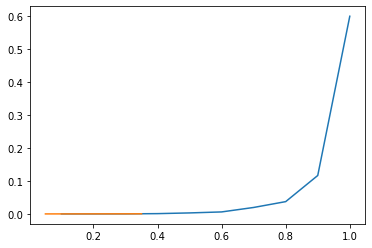

In [260]:
inter_rng = np.linspace(.05, .35, 500)
log_tau_lst = np.log10(tau_lst[-3:])
inter_func = np.power(10, interpf(inter_rng, v0_lst[-3:], log_tau_lst[-3:]))
plt.plot(v0_lst, tau_lst)
plt.plot(inter_rng, inter_func)
tau_halley = inter_func[np.argmin(np.abs(inter_rng - v_halley))]
print(tau_halley)

Text(0.396, 0.8, "Halley's Comet Calculated Values:\n$V_0$:   0.192962\n$\\tau$:     1.7912e-05")

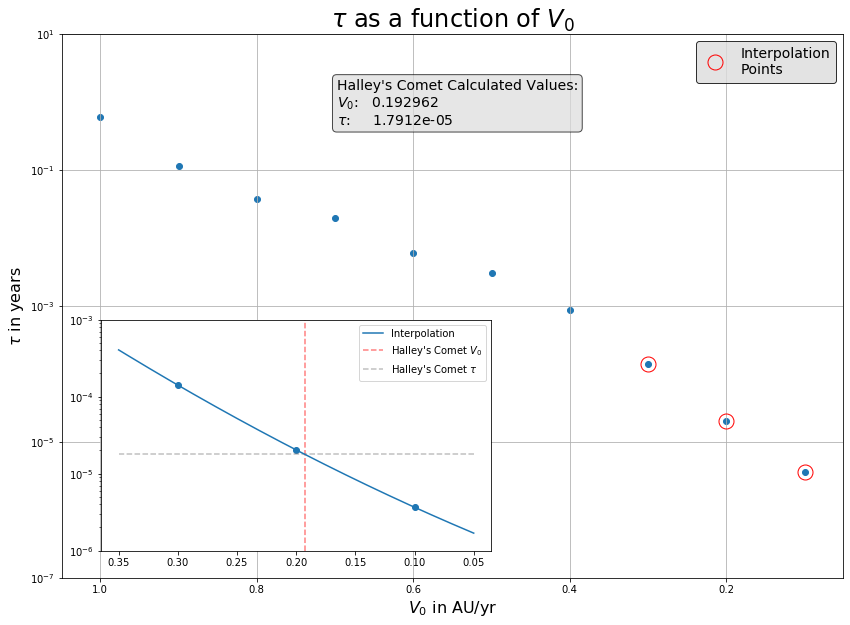

In [92]:
fig, ax = plt.subplots(figsize=(14,10))
axin = ax.inset_axes([0.05, 0.05, 0.5, 0.425])
axin.scatter(v0_lst[-3:], tau_lst[-3:])
axin.plot(inter_rng, inter_func, label = 'Interpolation')
axin.vlines(v_halley, 1e-06, 1e-03, alpha = .5, color = 'red',
            ls = 'dashed', label = 'Halley\'s Comet $V_0$')
axin.hlines(tau_halley, .05, .35, alpha = .5, color = 'grey',
            ls = 'dashed', label = 'Halley\'s Comet $\\tau$')
axin.set_yscale('log')
axin.set_ylim(1e-06, 1e-03)
axin.invert_xaxis()
axin.legend()
ax.scatter(v0_lst, tau_lst)
ax.plot(v0_lst[-3:], tau_lst[-3:], 'ro', fillstyle = 'none', 
        markersize = 15, label = 'Interpolation\nPoints')
ax.set_yscale('log')
ax.set_ylim(1e-07, 1e01)
ax.invert_xaxis()
ax.legend(fontsize = 14, facecolor = 'gainsboro', edgecolor = 'black')
ax.grid(True)
ax.set_title('$\\tau$ as a function of $V_0$', fontsize = 24)
ax.set_xlabel('$V_0$ in AU/yr', fontsize = 16)
ax.set_ylabel('$\\tau$ in years', fontsize = 16)
ax.annotate('Halley\'s Comet Calculated Values:\n$V_0$:   %.6g\n$\\tau$:     %.6g'%
             (v_halley, tau_halley), xy = (.396, .8), xycoords = 'figure fraction', 
            fontsize = 14, bbox=dict(boxstyle="round", alpha = .7, fc="gainsboro"))

In [263]:
r0 = 35
v0 = v_halley
nStep = 10000000
tau = tau_halley
time = 0
margin = 1e-3

GM = 4*np.pi**2     #(AU^3/yr^2)
mass = 1

r = np.array([r0, 0])
v = np.array([0, v0])
rplot = np.empty(nStep)
thplot = np.empty(nStep)
tplot = np.empty(nStep)
potential = np.empty(nStep)
kinetic = np.empty(nStep)

for i in range(nStep):
    rplot[i] = la.norm(r)
    thplot[i] = np.arctan2(r[1],r[0])
    tplot[i] = time
    kinetic[i] = .5*mass*la.norm(v)**2
    potential[i] = -GM*mass/la.norm(r)

    r, v, time = eulcro(r, v, time, tau, GM)

    if i > int(1 / tau):
        if (rplot[i] < rplot[i - 1]) and np.abs(thplot[i]) < margin:
            break
            
i += 1
kinetic = kinetic[:i]
potential = potential[:i]
tplot = tplot[:i]
rplot = rplot[:i]
thplot = thplot[:i]
totalE = kinetic + potential
dev_E = np.abs((totalE[0] - totalE[-1])/np.mean(totalE)) * 100
dev_E_abs = np.abs((np.max(totalE) - np.min(totalE))/np.mean(totalE)) * 100

print('---------------------COMPLETED---------------------\
\nEnergy Deviation over entire range: %.2g \nEnergy Deviation on endpoints: %.2g '%
      (dev_E_abs, dev_E))

---------------------COMPLETED---------------------
Energy Deviation over entire range: 0.54 
Energy Deviation on endpoints: 1.2e-10 


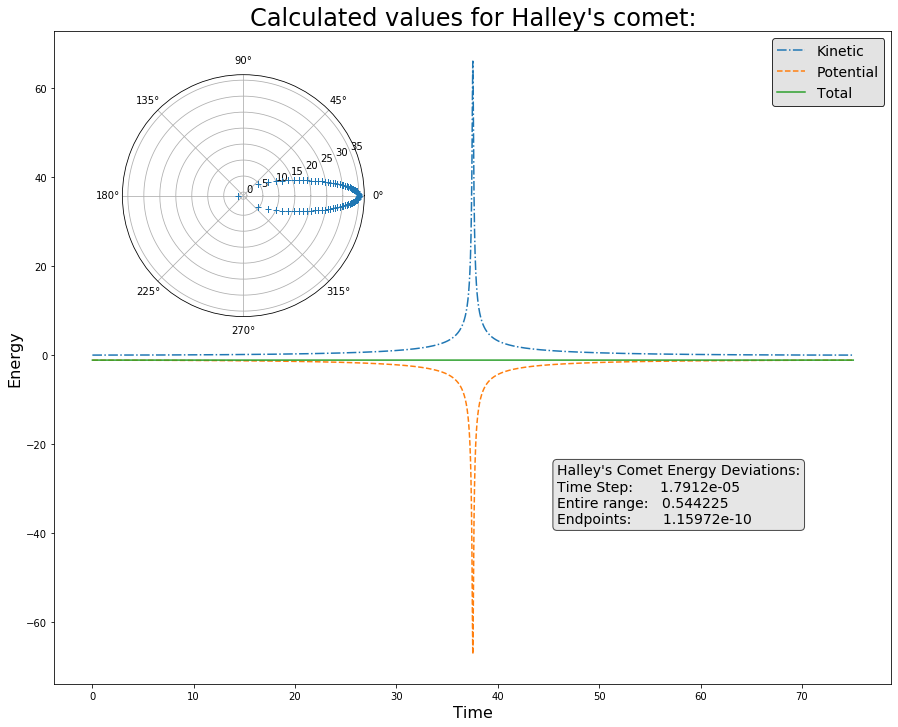

In [264]:
fig = plt.figure(figsize = (15, 12))
plt.title('Calculated values for Halley\'s comet:', fontsize = 24)
totalE = np.array(kinetic) + np.array(potential)
plt.plot(tplot, kinetic, '-.', label = 'Kinetic')
plt.plot(tplot, potential, '--', label = 'Potential')
plt.plot(tplot, totalE, '-', label = 'Total')
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Energy', fontsize = 16)
plt.legend(loc = 'upper right', facecolor = 'gainsboro',
          edgecolor = 'black', fontsize = 14)
plt.annotate('Halley\'s Comet Energy Deviations:\nTime Step:      %.6g\
\nEntire range:   %.6g\nEndpoints:       %.6g'%
             (tau_halley, dev_E_abs, dev_E), xy = (.62, .28), xycoords = 'figure fraction', 
            fontsize = 14, bbox=dict(boxstyle="round", alpha = .7, fc="gainsboro"))
ax = fig.add_axes([.16, .55, .28, .28], polar = True)
ax.plot(thplot[::52379], rplot[::52379], '+')
plt.show()

# Problem 3.11

In [239]:
'''
Warning: This cell takes quite a while to run
'''
r0 = 35
v0_lst = np.arange(1,0,-.1)
mass = 1            
GM = 4*np.pi**2     #(AU^3/yr^2)
nStep = 10**5

tau_lst = np.empty_like(v0_lst)
deve_lst = np.empty_like(v0_lst)
deve_abs_lst = np.empty_like(v0_lst)
j = 0

for v0 in v0_lst:
    dev_E = 2
    dev_E_abs = 2
    tau = 15 * v0

    while dev_E_abs > 1:
        print('Test', v0, dev_E_abs, tau)
        r = np.array([r0, 0])
        v = np.array([0, v0])
        state = np.array([r[0], r[1], v[0], v[1]])
        rplot = np.empty(nStep)
        thplot = np.empty(nStep)
        tplot = np.empty(nStep)
        potential = np.empty(nStep)
        kinetic = np.empty(nStep)
        time = 0
        i = 0

        for i in range(nStep):
            rplot[i] = la.norm(r)
            thplot[i] = np.arctan2(r[1],r[0])
            tplot[i] = time
            kinetic[i] = .5*mass*la.norm(v)**2
            potential[i] = -GM*mass/la.norm(r)

            state = rk4(state, time, tau, gravrk, GM)
            r = [state[0], state[1]]
            v = [state[2], state[3]]
            time = time + tau

            if i > 1:
                if (thplot[i] * thplot[i - 1]) < 0 and np.abs(thplot[i]) < margin:
                    print('Break')
                    break

        i += 1
        kinetic = kinetic[:i]
        potential = potential[:i]
        totalE = kinetic + potential
        dev_E = np.abs((totalE[0] - totalE[-1])/np.mean(totalE)) * 100
        dev_E_abs = np.abs((np.max(totalE) - np.min(totalE))/np.mean(totalE)) * 100
        tauF = tau   
        tau *= .6

    tau_lst[j] = tau
    deve_lst[j] = dev_E
    deve_abs_lst[j] = dev_E_abs
        
    j += 1   

print('|-------- Completed --------|')

Test 1.0 2 15.0
Break
Test 1.0 7.0437816666899815 9.0
Break
Test 0.9 2 13.5
Break
Test 0.9 8.895599094269489 8.1
Break
Test 0.9 1.4417012882464746 4.859999999999999
Break
Test 0.8 2 12.0
Test 0.8 125.05979768064543 7.199999999999999
Break
Test 0.8 11.921934953749352 4.319999999999999
Break
Test 0.7000000000000001 2 10.500000000000002
Test 0.7000000000000001 131.80068449023855 6.300000000000001
Test 0.7000000000000001 116.02473876022523 3.7800000000000002
Break
Test 0.7000000000000001 4.836306624152231 2.2680000000000002
Break
Test 0.6000000000000001 2 9.000000000000002
Test 0.6000000000000001 557.6784887848034 5.400000000000001
Break
Test 0.6000000000000001 57.10995129136043 3.2400000000000007
Break
Test 0.6000000000000001 29.170431720000035 1.9440000000000004
Break
Test 0.6000000000000001 4.472896867726203 1.1664
Break
Test 0.5000000000000001 2 7.500000000000002
Test 0.5000000000000001 179.01065522359002 4.500000000000001
Test 0.5000000000000001 105.38892752609044 2.7000000000000006
T

In [241]:
'''
These values were obtained by running the above cell, but I wanted to retain them if I need
to restart the kernel
'''

tau_lst = np.array([5.40000000e+00, 2.91600000e+00, 2.59200000e+00, 1.36080000e+00,
                    6.99840000e-01, 3.49920000e-01, 1.67961600e-01, 4.53496320e-02,
                    1.08839117e-02, 1.17546246e-03])
v_halley = .19296234915     #AU/yr -- calculated

0.009574517536271398


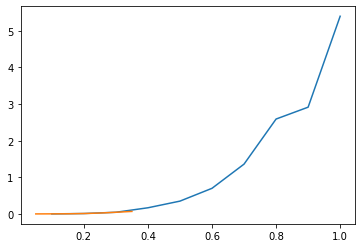

In [242]:
inter_rng = np.linspace(.05, .35, 500)
log_tau_lst = np.log10(tau_lst[-3:])
inter_func = np.power(10, interpf(inter_rng, v0_lst[-3:], log_tau_lst[-3:]))
plt.plot(v0_lst, tau_lst)
plt.plot(inter_rng, inter_func)
tau_halley = inter_func[np.argmin(np.abs(inter_rng - v_halley))]
print(tau_halley)

Text(0.396, 0.82, "Halley's Comet Calculated Values:\n$V_0$:   0.192962\n$\\tau$:     0.00957452")

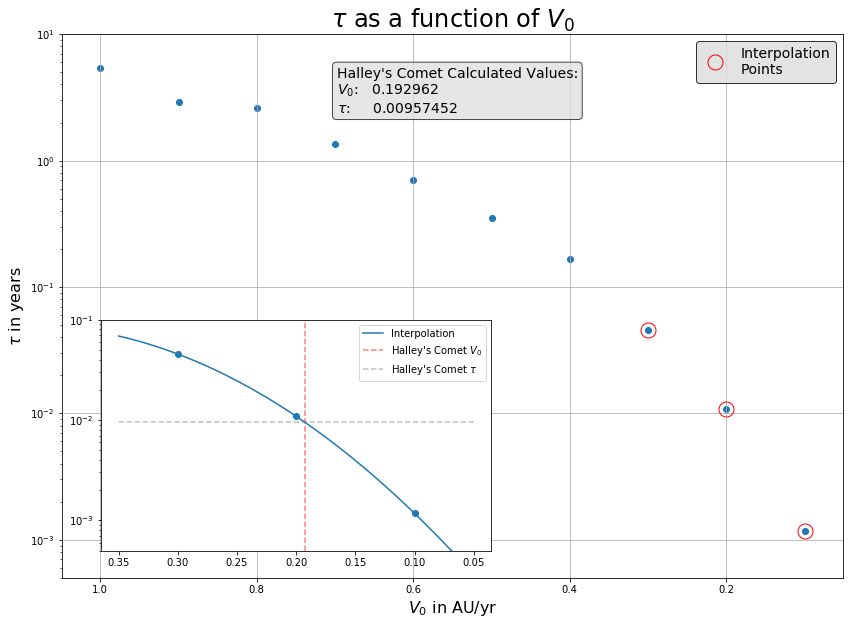

In [249]:
fig, ax = plt.subplots(figsize=(14,10))
axin = ax.inset_axes([0.05, 0.05, 0.5, 0.425])
axin.scatter(v0_lst[-3:], tau_lst[-3:])
axin.plot(inter_rng, inter_func, label = 'Interpolation')
axin.set_ylim(5e-04, 1e-01)
axin.vlines(v_halley, 5e-04, 1e-01, alpha = .5, color = 'red',
            ls = 'dashed', label = 'Halley\'s Comet $V_0$')
axin.hlines(tau_halley, .05, .35, alpha = .5, color = 'grey',
            ls = 'dashed', label = 'Halley\'s Comet $\\tau$')
axin.set_yscale('log')
axin.invert_xaxis()
axin.legend()
ax.scatter(v0_lst, tau_lst)
ax.plot(v0_lst[-3:], tau_lst[-3:], 'ro', fillstyle = 'none', 
        markersize = 15, label = 'Interpolation\nPoints')
ax.set_yscale('log')
ax.set_ylim(5e-04, 1e01)
ax.invert_xaxis()
ax.legend(fontsize = 14, facecolor = 'gainsboro', edgecolor = 'black')
ax.grid(True)
ax.set_title('$\\tau$ as a function of $V_0$', fontsize = 24)
ax.set_xlabel('$V_0$ in AU/yr', fontsize = 16)
ax.set_ylabel('$\\tau$ in years', fontsize = 16)
ax.annotate('Halley\'s Comet Calculated Values:\n$V_0$:   %.6g\n$\\tau$:     %.6g'%
             (v_halley, tau_halley), xy = (.396, .82), xycoords = 'figure fraction', 
            fontsize = 14, bbox=dict(boxstyle="round", alpha = .7, fc="gainsboro"))

In [253]:
r0 = 35
v0 = v_halley
nStep = 10000000
tau = tau_halley
time = 0
margin = 1e-3

GM = 4*np.pi**2     #(AU^3/yr^2)
mass = 1

r = np.array([r0, 0])
v = np.array([0, v0])
state = np.array([r[0], r[1], v[0], v[1]])
rplot = np.empty(nStep)
thplot = np.empty(nStep)
tplot = np.empty(nStep)
potential = np.empty(nStep)
kinetic = np.empty(nStep)
time = 0
i = 0

for i in range(nStep):
    rplot[i] = la.norm(r)
    thplot[i] = np.arctan2(r[1],r[0])
    tplot[i] = time
    kinetic[i] = .5*mass*la.norm(v)**2
    potential[i] = -GM*mass/la.norm(r)

    state = rk4(state, time, tau, gravrk, GM)
    r = [state[0], state[1]]
    v = [state[2], state[3]]
    time = time + tau

    if i > 1:
        if (thplot[i] * thplot[i - 1]) < 0 and np.abs(thplot[i]) < margin:
            break

i += 1
kinetic = kinetic[:i]
potential = potential[:i]
tplot = tplot[:i]
rplot = rplot[:i]
thplot = thplot[:i]
totalE = kinetic + potential
dev_E = np.abs((totalE[0] - totalE[-1])/np.mean(totalE)) * 100
dev_E_abs = np.abs((np.max(totalE) - np.min(totalE))/np.mean(totalE)) * 100

print('---------------------COMPLETED---------------------\
\nEnergy Deviation over entire range: %.2g \nEnergy Deviation on endpoints: %.2g '%
      (dev_E_abs, dev_E))

---------------------COMPLETED---------------------
Energy Deviation over entire range: 0.025 
Energy Deviation on endpoints: 0.015 


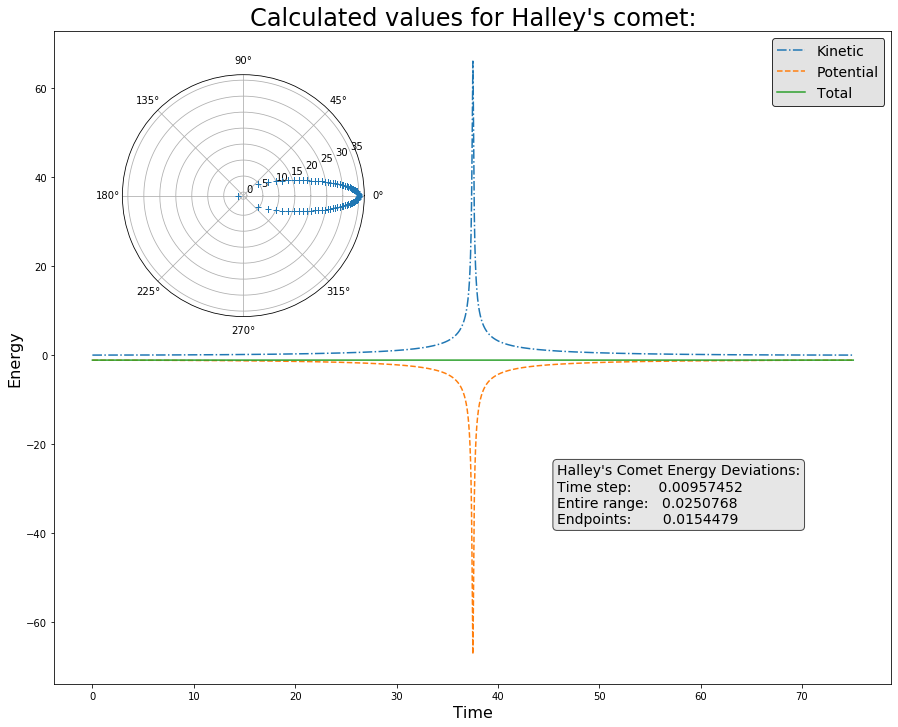

In [258]:
fig = plt.figure(figsize = (15, 12))
plt.title('Calculated values for Halley\'s comet:', fontsize = 24)
totalE = np.array(kinetic) + np.array(potential)
plt.plot(tplot, kinetic, '-.', label = 'Kinetic')
plt.plot(tplot, potential, '--', label = 'Potential')
plt.plot(tplot, totalE, '-', label = 'Total')
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Energy', fontsize = 16)
plt.legend(loc = 'upper right', facecolor = 'gainsboro',
          edgecolor = 'black', fontsize = 14)
plt.annotate('Halley\'s Comet Energy Deviations:\nTime step:      %.6g\
\nEntire range:   %.6g\nEndpoints:       %.6g'%
             (tau_halley, dev_E_abs, dev_E), xy = (.62, .28), xycoords = 'figure fraction', 
            fontsize = 14, bbox=dict(boxstyle="round", alpha = .7, fc="gainsboro"))
ax = fig.add_axes([.16, .55, .28, .28], polar = True)
ax.plot(thplot[::98], rplot[::98], '+')
plt.show()

# Problem 3.14

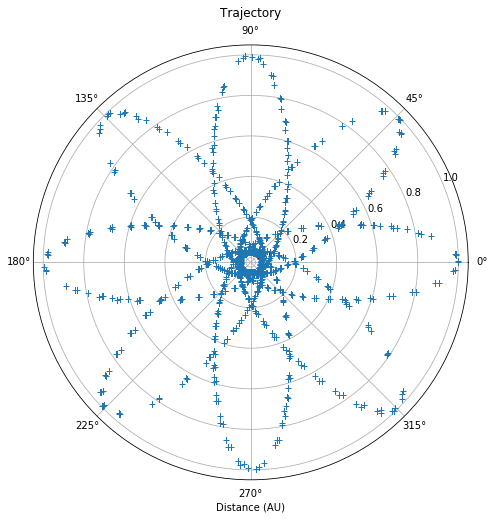

In [269]:
#Initialize variables
def grav2(s,t,GM):
    #alpha = .019132653061
    alpha = -.013117283951
    # Compute acceleration
    r = np.array([s[0], s[1]]) 
    v = np.array([s[2], s[3]])
    accel = -(GM*r/la.norm(r)**3) * (1-(alpha/la.norm(r))) 

    # Return derivatives [dr(1)/dt dr(2)/dt dv(1)/dt dv(2)/dt]
    deriv = np.array([v[0], v[1], accel[0], accel[1]])
    return deriv

r0 = 1
v0 = np.pi/2
nStep = 1000
tau = .005
r = np.array([r0, 0])
v = np.array([0, v0])
state = np.array([r[0], r[1], v[0], v[1]])
errflag = 0
alpha = .59466991411

rplot=[]
tplot=[]
thplot=[]
kinetic=[]
potential=[]

GM = 4*np.pi**2    
mass = 1            
adaptErr = 1e-3     #Adaptive error parameter
time = 0           


for i in range(nStep):
    
    #PLot arrays
    
    rplot.append(la.norm(r))
    thplot.append(np.arctan2(r[1],r[0]))
    tplot.append(time)
    kinetic.append(.5*mass*la.norm(v)**2)
    potential.append(-GM*mass/la.norm(r))

    [state, time, tau] = rka(state, time, tau, adaptErr, grav2, GM)
    r = [state[0], state[1]]
    v = [state[2], state[3]]
    time = time + tau
    
#plot trajectory

plt.figure(figsize = (8,8))
plt.subplot(111, projection = 'polar')
plt.title('Trajectory')
plt.polar(thplot, rplot, '+')
plt.xlabel('Distance (AU)')
plt.show()

In [283]:
maxes = [int(rplot[0])]
for i in range(len(rplot)):
    if i>2:
        if rplot[i] < rplot[i-1] and rplot[i-1] > rplot[i-2]:
            maxes.append(i-1)
thplot = np.asarray(thplot)
maxes = np.asarray(maxes)
print(thplot[maxes]*180/np.pi)

[   0.45014081   43.60088584   91.68997463  133.26408066 -178.69272303
 -136.04625076  -88.58266387  -46.09793811    2.21539895   44.0533156
   92.17917636  133.90319446 -177.91126949 -135.80657619  -90.75485772
  -46.36477892    1.95709078   44.33492989   89.70195598  134.4673552
 -177.64289196 -135.66781813  -87.60939604  -45.30122642]


# Problem 3.15

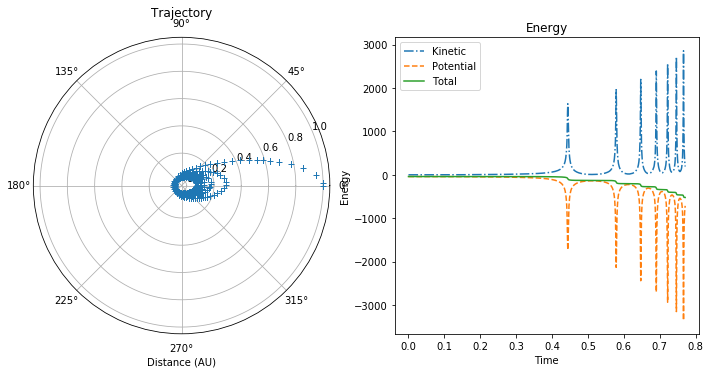

In [284]:
def gravdrag(s,t,GM):
    c = .16
    r = np.array([s[0], s[1]]) 
    v = np.array([s[2], s[3]])
    accel = -GM*r/la.norm(r)**3 - c*la.norm(v)*v

    deriv = np.array([v[0], v[1], accel[0], accel[1]])
    return deriv

r0 = 1
v0 = np.pi/2
nStep = 300
tau = .01
r = np.array([r0, 0])
v = np.array([0, v0])
state = np.array([r[0], r[1], v[0], v[1]])
errflag = 0

rplot=[]
tplot=[]
thplot=[]
kinetic=[]
potential=[]

GM = 4*np.pi**2     
mass = 1           
adaptErr = 1e-4     
time = 0            

for i in range(nStep):

    rplot.append(la.norm(r))
    thplot.append(np.arctan2(r[1],r[0]))
    tplot.append(time)
    kinetic.append(.5*mass*la.norm(v)**2)
    potential.append(-GM*mass/la.norm(r))

    [state, time, tau] = rka(state, time, tau, adaptErr, gravdrag, GM)
    r = [state[0], state[1]]
    v = [state[2], state[3]]
    time = time + tau

plt.figure(figsize = (12,12))
plt.subplot(221, projection = 'polar')
plt.title('Trajectory')
plt.polar(thplot, rplot, '+')
plt.xlabel('Distance (AU)')

plt.subplot(222)
plt.title('Energy')
totalE = np.array(kinetic) + np.array(potential)
plt.plot(tplot, kinetic, '-.', label = 'Kinetic')
plt.plot(tplot, potential, '--', label = 'Potential')
plt.plot(tplot, totalE, '-', label = 'Total')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [299]:
maxes = []
for i in range(len(kinetic)):
    if kinetic[i] < kinetic[i-1] and kinetic[i-1] > kinetic[i-2]:
        maxes.append(i-1)
tplot = np.asarray(tplot)
kinetic = np.asarray(kinetic)
potential = np.asarray(potential)
totalE = np.asarray(totalE)
maxes = np.asarray(maxes)
avgs = np.empty([3, len(maxes)])
a = 0
j = 0
for i in maxes:
    avgs[0, j] = np.mean(kinetic[a:i])
    avgs[1, j] = np.mean(potential[a:i])
    avgs[2, j] = np.mean(totalE[a:i])
    a = i
    j += 1
print(avgs)

[[  396.57744408   558.57445571   690.39785161   800.33472019
    893.01606324   972.3307432   1069.30172505]
 [ -449.89576611  -686.10246373  -892.94180708 -1072.42787881
  -1230.80216087 -1373.08268352 -1531.30670085]
 [  -53.31832203  -127.52800802  -202.54395547  -272.09315862
   -337.78609763  -400.75194031  -462.00497581]]


Text(0, 0.5, 'Average energy')

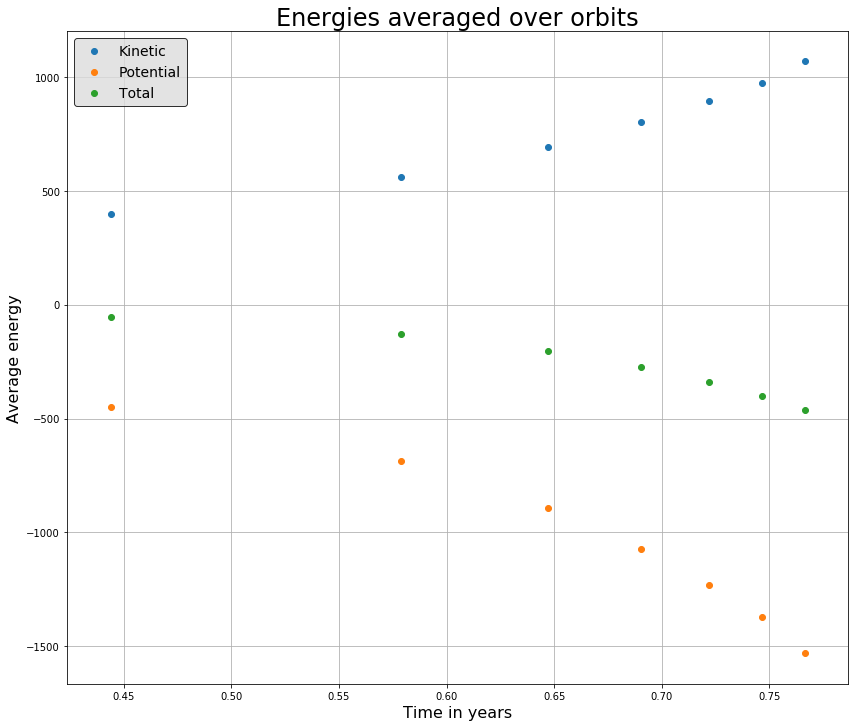

In [309]:
fig, ax = plt.subplots(figsize = (14,12))
ax.scatter(tplot[maxes], avgs[0,:], label = 'Kinetic')
ax.scatter(tplot[maxes], avgs[1,:], label = 'Potential')
ax.scatter(tplot[maxes], avgs[2,:], label = 'Total')
ax.grid(True)
ax.legend(fontsize = 14, facecolor = 'gainsboro', 
          loc = 'upper left', edgecolor = 'black')
ax.set_title('Energies averaged over orbits', fontsize = 24)
ax.set_xlabel('Time in years', fontsize = 16)
ax.set_ylabel('Average energy', fontsize = 16)